In [1]:
import socket,warnings

try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
    print("Connection success")
except socket.error as ex: raise Exception("STOP: No internet. Click '|<' in buttom right and set 'Internet' switch to on")

Connection success


### Download Chessman image dataset
["chessman-image-dataset"](https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset)

In [2]:
import kagglehub

path = kagglehub.dataset_download("niteshfre/chessman-image-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chessman-image-dataset


### Inspect datase directory

In [15]:
!ls -R /kaggle/input/chessman-image-dataset | head -40



/kaggle/input/chessman-image-dataset:
chessman-image-dataset
Chessman-image-dataset

/kaggle/input/chessman-image-dataset/chessman-image-dataset:
Chessman-image-dataset

/kaggle/input/chessman-image-dataset/chessman-image-dataset/Chessman-image-dataset:
Chess

/kaggle/input/chessman-image-dataset/chessman-image-dataset/Chessman-image-dataset/Chess:
Bishop
King
Knight
Pawn
Queen
Rook

/kaggle/input/chessman-image-dataset/chessman-image-dataset/Chessman-image-dataset/Chess/Bishop:
00000000.JPG
00000001.jpg
00000002.JPG
00000003.png
00000004.jpg
00000006.jpg
00000007.jpg
00000008.jpg
00000009.png
00000010.jpg
00000011.jpg
00000012.jpg
00000013.jpg
00000015.png
00000016.jpg
00000017.jpg
00000018.jpg
00000019.jpg
00000020.jpg
00000024.jpg
00000025.jpg
ls: write error: Broken pipe


In [16]:
!cd /kaggle/input/chessman-image-dataset/chessman-image-dataset/Chessman-image-dataset/Chess && pwd && ls -l

/kaggle/input/chessman-image-dataset/chessman-image-dataset/Chessman-image-dataset/Chess
total 0
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Bishop
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 King
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Knight
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Pawn
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Queen
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Rook


### Use images from `Chess` dir to train a model

In [18]:
from pathlib import Path

data_path = Path("/kaggle/input/chessman-image-dataset/Chessman-image-dataset/Chess")

# list first 10 directories
!ls -l "$data_path" | head
# list total number of directories
!ls -l "$data_path" | wc -l

total 0
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Bishop
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 King
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Knight
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Pawn
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Queen
drwxr-xr-x 2 nobody nogroup 0 Sep  4 20:31 Rook
7


In [20]:
from fastai.vision.all import *
print("Done")

Done


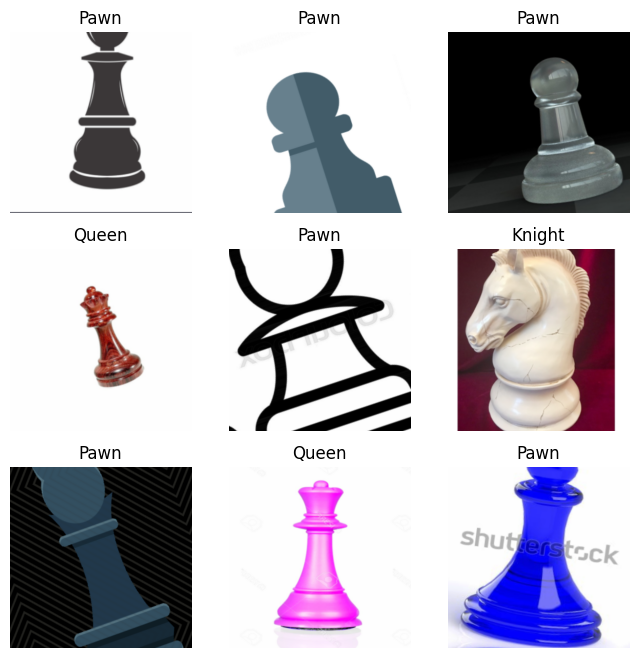

In [21]:
# Build DataLoaders (with an 80/20 train/validation split)
dls = ImageDataLoaders.from_folder(
    data_path,       # path to dataset folder (subfolders = class names)
    valid_pct=0.2,   # use 20% of data for validation, 80% for training
    seed=42,         # random seed for reproducibility

    # Item-level transforms (applied to each image individually, before batching)
    # RandomResizedCrop randomly crops a portion of the image and resizes it to 320x320
    #   - Adds variation in scale & position (better generalization than plain Resize)
    #   - min_scale=0.6 → crop covers at least 60% of the original image
    #   - ratio=(0.75, 1.33) → allow aspect ratio variation (not only square)
    item_tfms=RandomResizedCrop(320, min_scale=0.6, ratio=(0.75, 1.33)),

    # Batch-level transforms (applied to a batch of images, on the GPU if available)
    # aug_transforms adds standard augmentations:
    #   - mult=2.0         : strength multiplier (how aggressive the augs are)
    #   - do_flip=True     : allow random horizontal flips
    #   - flip_vert=False  : don’t flip vertically (pieces would look upside-down)
    #   - max_rotate=10    : small random rotations (±10°)
    #   - max_zoom=1.10    : random zoom up to 10%
    #   - max_lighting=0.2 : random brightness/contrast changes
    #   - max_warp=0.0     : no perspective warping (can distort shapes too much)
    #   - p_affine=0.75    : probability of applying affine transforms (rotate/zoom/shift)
    #   - p_lighting=0.75  : probability of applying lighting transforms
    # Normalize.from_stats(*imagenet_stats) normalizes inputs using ImageNet mean/std
    #   → ensures compatibility with pretrained models (like ResNet/EfficientNet)
    batch_tfms=(
        aug_transforms(
            mult=2.0,
            do_flip=True,
            flip_vert=False,
            max_rotate=10,
            max_zoom=1.10,
            max_lighting=0.2,
            max_warp=0.0,
            p_affine=0.75,
            p_lighting=0.75
        )
        + [Normalize.from_stats(*imagenet_stats)]
    ),

    # DataLoader parameters
    bs=64,        # batch size = 64 (reduce if GPU runs out of memory, e.g. 32)
    num_workers=4 # parallel workers to load data (0 on Windows if issues)
)

dls.show_batch(max_n=9, figsize=(8,8))

### Count total images

In [22]:
imgs = get_image_files(path)
print("Total images found:", len(imgs))

Total images found: 1104


### Start learning

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Start learning


epoch,train_loss,valid_loss,error_rate,time
0,2.672737,1.592491,0.545455,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.459566,1.086447,0.345455,00:24
1,1.141779,0.725830,0.263636,00:25
2,0.950760,0.558876,0.254545,00:24
3,0.809954,0.484800,0.218182,00:24
4,0.696758,0.465318,0.181818,00:24


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

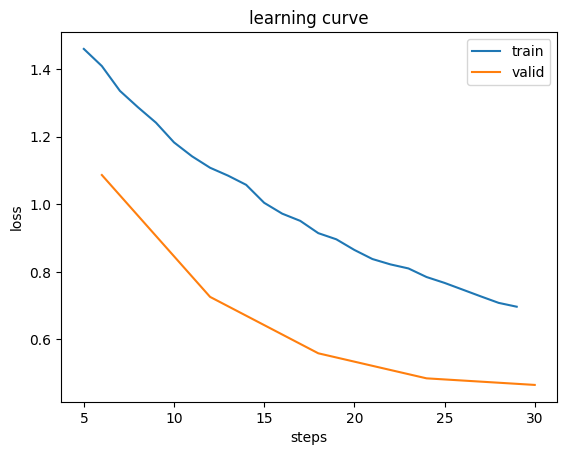

In [13]:
learn = vision_learner(dls, 'convnext_tiny', metrics=error_rate)

print("Start learning")
learn.fine_tune(5)
learn.recorder.plot_loss()

### Test

Sample image: /kaggle/input/chessman-image-dataset/Chessman-image-dataset/Chess/King/00000134.jpg


<Axes: >

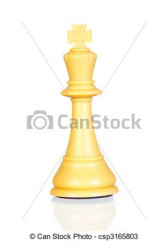

In [14]:
import random

# pick random image from validation set
img_path = random.choice(dls.valid_ds.items)
print("Sample image:", img_path)

img = PILImage.create(img_path)
img.show(figsize=(3,3))

In [15]:
# Run inference on a single image (img must be a PILImage or file path)
# Returns: (predicted class label, index of class in vocab, probabilities for all classes)
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}")
print(f"Class index: {pred_idx}")
print(f"Confidence: {probs[pred_idx]:.4f}")


Prediction: King
Class index: 1
Confidence: 0.8656


### Get the top-5 highest probabilities from the model's output

In [16]:
top5 = probs.topk(5)
for prob, idx in zip(top5.values, top5.indices):
    # dls.vocab gives the class names in the same order the model was trained
    # idx is the integer index of the predicted class
    # prob is the confidence (between 0 and 1)
    print(f"{dls.vocab[idx]}: {prob:.4f}")

King: 0.8656
Queen: 0.0857
Bishop: 0.0436
Pawn: 0.0024
Rook: 0.0018


King:   0.8656  → model is ~86.6% confident this is a King

Queen:  0.0857  → ~8.6% chance

Bishop: 0.0436  → ~4.4% chance

Pawn:   0.0024  → ~0.2% chance

Rook:   0.0018  → ~0.2% chance


### Save trained model

In [27]:
learn.export('/kaggle/working/chessman_model.pkl')

### Use Gradio for visualization

In [ ]:
import gradio as gr
from fastai.vision.all import PILImage

# fastai's learner already exists: learn

def classify_image(img):
    # Gradio will pass a PIL.Image if we set type="pil"
    pred_class, pred_idx, probs = learn.predict(PILImage.create(img))
    # Return top-3 as a dict for gr.Label
    topk = probs.topk(3)
    return {learn.dls.vocab[i]: float(probs[i]) for i in topk.indices}

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="Upload chess piece", height=320),
    outputs=gr.Label(num_top_classes=3, label="Prediction"),
    examples=None,  # or provide actual existing image paths
)

# In Kaggle notebooks, inline=True usually works; if not, use share=True
demo.launch(inline=True, debug=True)


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://53a15fd3fd54b208ce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
